## EXERCISE 1: Design, Train and Test a CNN

Create a CNN using Keras library with the followings specifications:

> __QUESTION 1(a):__  DATASET: Load the [CIFAR10](https://keras.io/api/datasets/cifar10/) dataset contains 60,000 color images in 10 classes, with 6,000 images in each class.
You can use the function datasets.cifar10.load_data() to load the dataset after importing the keras dataset with the command: from tensorflow.keras import datasets. Split the dataset in train and test set

> __QUESTION 1(b):__  Plot some samples in the dataset to visualize the kind of data

> __QUESTION 1(c):__  Build and compile a CNN model composed with:
* Conv2D with 32 filters, kernel size 3X3, activation function relu
* MaxPooling 2D with kernel size 2x2
* Conv2D with 64 filters kernel size 3X3, activation function relu
* MaxPooling 2D with kernel size 2x2
* Conv2D with 64 filters kernel size 3X3, activation function relu
* Flatten layer
* Dense layer with 64 neurons and activation function relu
* Final Dense layer for returning 10 classes
* adam as optmizer


> __QUESTION 1(d):__ Train and test on the CIFAR10 dataset with 10 epochs to check the performance

> __QUESTION 1(e):__ Compute the confusion matrix

> __QUESTION 1(f):__ : Test your model on new images about the available class that you can download from the web.

---
## 1. Installazione dipendenze e abilitazione GPU

In [13]:
!pip install gdown

In [14]:
# ----- LIBRERIE -----
# tensorflow e keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image

# matplotlib e pyplot
import matplotlib.pyplot as plt

# numpy
import numpy as np

# per confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# per file da internt
import gdown

# ----- ACCELERAZIONE con GPU -----
# abilitazione exploit GPU per accelerare l'addestramento
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

# ----- BATCH SIZE -----
BATCH_SIZE = 128

---
## 2. Caricamento dataset, verifica, normalizzazione e ottimizzazione del dataset

In [15]:
# ----- CARICAMENTO DATASET, NOME CLASSI -----
# dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# mappatura labels - nomeclassi per il dataset CIFAR-10
class_names = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}


# ----- VERIFICA DATASET -----
# stampa dimensioni dei dataset
print("----- DATASET SIZE AND SHAPE -----")
print("x_train dataset size:", x_train.shape)
print("y_train dataset size:", y_train.shape)
print("x_test dataset size:", x_test.shape)
print("x_test dataset size:", y_test.shape)

----- DATASET SIZE AND SHAPE -----
x_train dataset size: (50000, 32, 32, 3)
y_train dataset size: (50000, 1)
x_test dataset size: (10000, 32, 32, 3)
x_test dataset size: (10000, 1)


----- DATASET EXAMPLES -----


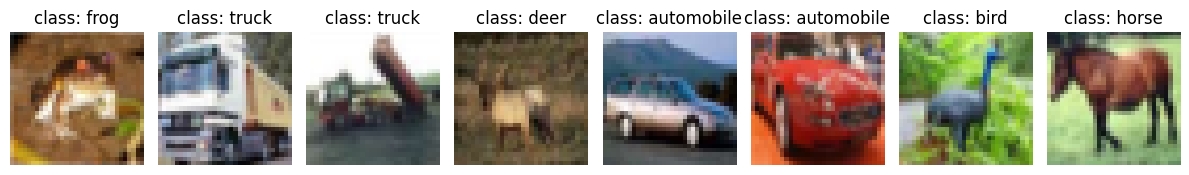

In [16]:
# stampa immagini e relativa classe
print("----- DATASET EXAMPLES -----")

# creazione figura 4x4 di dimensione 8x8 pollici
fig, axes = plt.subplots(1, 8, figsize=(12,2))

# per ogni subplot (ax) carica l'immagine con la relativa classe
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].astype("uint8")) # interpreto i valori RGB come interi [0,255]
    ax.set_title("class: " + class_names[y_train[i][0]])
    ax.axis("off")

# stampa la tabella ottenuta
plt.tight_layout()
plt.show()

----- RGB VALUES NORMALIZATION -----


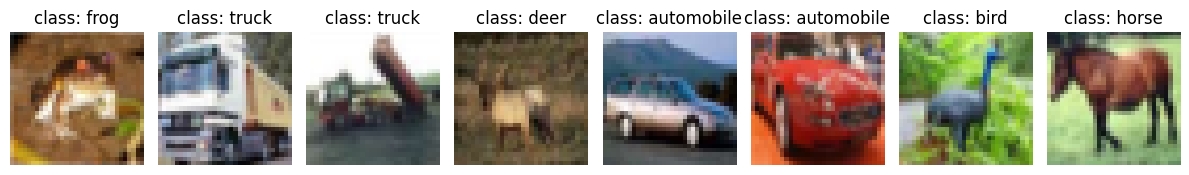

In [17]:
# ----- RGB VALUES NORMALIZATION -----
# conversione delle immagini in modo da normalizzare i valori RGB da interi [0,255] a decimali [0,1]
x_train = x_train / 255
x_test = x_test / 255

# verifica della conversione da valori interi a decimali, per stampare le immagini con i colori effettivi si aggiunge
# l'attributo '.astype("float32")' per indicare di interpretare i valori RGB come decimali normalizzati in [0,1]
print("----- RGB VALUES NORMALIZATION -----")
fig, axes = plt.subplots(1, 8, figsize=(12,2))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].astype("float32"))
    ax.set_title("class: " + class_names[y_train[i][0]])
    ax.axis("off")
plt.tight_layout()
plt.show()

----- DATA AUGMENTATION EXAMPLES -----


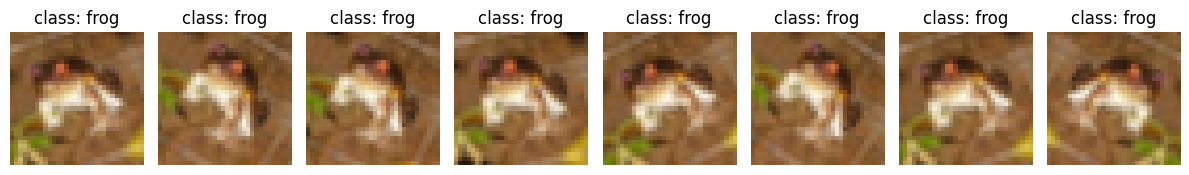

In [18]:
# ----- DATA AUGMENTATION EXAMPLE -----
# 1. l'operazione di data augmentation consiste nella creazione di un modello sequenziale con due layers che effettuano
#    operazioni di horizontan flip e random rotiation e che riceve in input singole immagini
# 2. il modello creato non viene usato per processare l'intero dataset perché elaborare immagini singole risulterebbe
#    troppo lento, l'operazione di data augmentation sull'intero dataset viene fatta successivamente dopo aver convertito
#    il dataset in batch di tensori TensorFlow e prima di effettuare il prefetch dei batch

# definizione del modello per data augmentation con layer di horizontal flip e layer di random rotation
single_image_data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

# stampa esemplificativa della stessa immagine a cui è stato applicato il filtro di data augmentation
print("----- DATA AUGMENTATION EXAMPLES -----")
fig, axes = plt.subplots(1, 8, figsize=(12,2))
for i, ax in enumerate(axes.flat):
    ax.imshow(single_image_data_augmentation(x_train[0]).numpy().astype("float32")) # uso RGB normalizzati in [0,1]
    ax.set_title("class: " + class_names[y_train[0][0]])
    ax.axis("off")
plt.tight_layout()
plt.show()

----- OPTIMIZED DATASET IMAGES WITH DATA AUGMENTATION -----


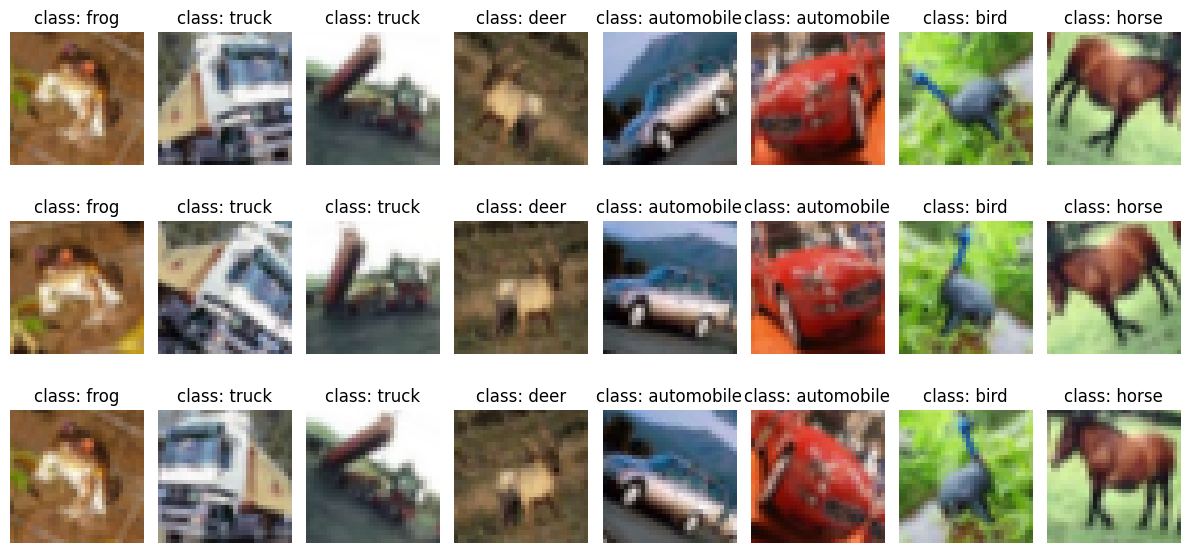

In [19]:
# ----- OPTIMIZING DATASET FOR PERFORMANCE -----
# definizione del modello di data augmentation che accetta batch e non immagini singole
batch_data_augmentation = tf.keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

# conversione dei vettori del dataset in tensori di TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# ottimizzazioni del dataset di training
# 1. tiene i dati in memoria RAM dopo la prima epoca
#train_ds = train_ds.cache()
#test_ds = test_ds.cache()

# 2. rimescola i dati per l'addestramento
#train_ds = train_ds.shuffle(buffer_size=1000)
#test_ds = test_ds.shuffle(buffer_size=1000)

# 3. suddivide il dataset in batch, ovvero insiemi di tensori che vengono elaborati in parallelo
train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# 4. effettua operazioni di data augmentation direttamente nel dataset per semplificare il modello CNN
train_ds = train_ds.map(lambda x, y: (batch_data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

# 5. effettua il prefetching, ovvero prepara il successivo batch da elaborare mentre la GPU lavora in modo da diminuire
#    i tempi di accesso e accelerare l'addestramento
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# stampa di parte del dataset di trainig per verifica
print("----- OPTIMIZED DATASET IMAGES WITH DATA AUGMENTATION -----")

# estrae tre esempi batch per poterli stampare (dovranno avere immagini diverse in quanto processate con funzioni
# di data augmentation con valori random
images_batch1, labels_batch1 = next(iter(train_ds))
images_batch2, labels_batch2 = next(iter(train_ds))
images_batch3, labels_batch3 = next(iter(train_ds))

# creo il grafico 3 righe (per ogni batch) x 8 immagini (dallo stesso batch)
fig, axes = plt.subplots(3, 8, figsize=(12,6))

# stampo immagini dal primo batch
for ax, img, label in zip(axes[0].flatten(), images_batch1, labels_batch1):
    ax.imshow(img.numpy().astype("float32"))
    ax.set_title("class: " + class_names[label.numpy()[0]])
    ax.axis("off")

# stampo immagini dal secondo batch
for ax, img, label in zip(axes[1].flatten(), images_batch2, labels_batch2):
    ax.imshow(img.numpy().astype("float32"))
    ax.set_title("class: " + class_names[label.numpy()[0]])
    ax.axis("off")

# stampo immagini dal terzo batch
for ax, img, label in zip(axes[2].flatten(), images_batch3, labels_batch3):
    ax.imshow(img.numpy().astype("float32"))
    ax.set_title("class: " + class_names[label.numpy()[0]])
    ax.axis("off")

# mando in stampa la matrice di immagini
plt.tight_layout()
plt.show()

---
## 3. Creazione del modello

In [20]:
model = tf.keras.Sequential([
    # struttura dell'input del modello
    layers.Input(shape=(32, 32, 3)),

    # Conv2D with 32 filters, kernel size 3X3, activation function relu
    layers.Conv2D(32, (3, 3), activation="relu"),

    # MaxPooling 2D with kernel size 2x2
    layers.MaxPooling2D((2,2)),

    # Conv2D with 64 filters kernel size 3X3, activation function relu
    layers.Conv2D(64, (3, 3), activation="relu"),

    # MaxPooling 2D with kernel size 2x2
    layers.MaxPooling2D((2,2)),

    # Conv2D with 64 filters kernel size 3X3, activation function relu
    layers.Conv2D(64, (3, 3), activation="relu"),

    # Flatten layer
    layers.Flatten(),

    # Dense layer with 64 neurons and activation function relu
    layers.Dense(64, activation="relu"),

    # Final Dense layer for returning 10 classes with activation function softmax
    # serve che l'ultimo layer abbia softmax perché la relu rischia di azzerare i valori negativi e di conseguenza
    # avere gradienti nulli che bloccano l'addestramento del modello su tali classi
    layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

---
## 4. Addestramento del modello

In [21]:
# prepazione intestazione output
print("----- ADDESTRAMENTO RETE NEURALE -----")

# compilazione del modello, con i seguenti parametri
# - optimizer: Adam (SGD evoluto) con learning rate 0.001
# - loss per classificatori multiclasse con layer finale di softmax (se non c'è softmax si usa from_logits=True)
# - misurazione delle performance: accuratezza
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# definizione funzione di scheduling per il LearningRateScheduler
# - learning rate 0.001 per epoche da 1 a 19
# - learning rate 0.0001 per epoche successive - fine tuning
def schedule_function(epoch, lr):
    if epoch < 20: return 0.001
    else: return 0.0001

# definizione della callback per il LearningRateScheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_function, verbose=0)


# definizione della callback per il ReduceLROnPlateau
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,       # Dividi LR per 5
    patience=3,       # Se non migliori per 3 epoche...
    min_lr=0.00001,   # ...abbassa, ma non scendere sotto questo valore
    verbose=1
)

# addestramento del modello con i seguenti parametri:
# - dataset "train_ds" normalizzato e ottimizzato in precedenza
# - dataset "test_ds" di validazione
# - callbacks a scelta tra lr_reduce (ReduceLROnPlateau) o lr_scheduler (LearningRateScheduler)
history = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=[lr_reduce], verbose=1)

----- ADDESTRAMENTO RETE NEURALE -----
Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.2813 - loss: 1.9529 - val_accuracy: 0.4691 - val_loss: 1.4589 - learning_rate: 0.0010
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4705 - loss: 1.4786 - val_accuracy: 0.5300 - val_loss: 1.3155 - learning_rate: 0.0010
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5202 - loss: 1.3489 - val_accuracy: 0.5796 - val_loss: 1.1925 - learning_rate: 0.0010
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5583 - loss: 1.2544 - val_accuracy: 0.5953 - val_loss: 1.1439 - learning_rate: 0.0010
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5783 - loss: 1.1944 - val_accuracy: 0.6083 - val_loss: 1.0988 - learning_rate: 0.0010
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5946 - loss: 1.1543 - val_accuracy: 0.6248 - val_loss: 1.0531 - learning_rate: 0.0010
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━

---
## 5. Analisi prestazioni

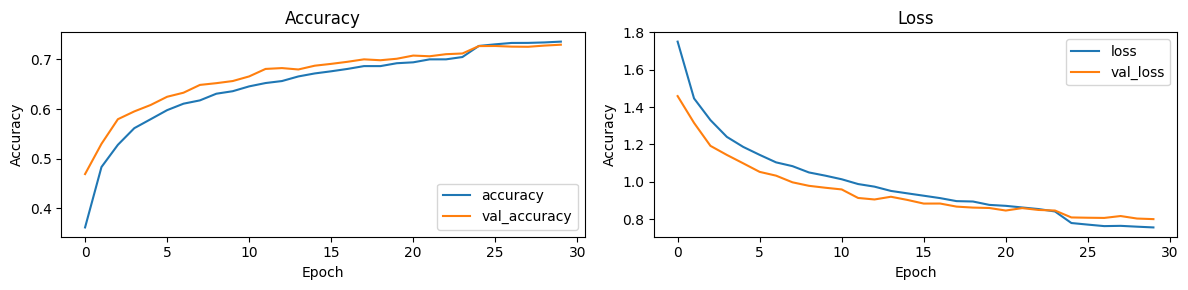

In [22]:
# analisi dell'evoluzione dell'accuratezza e della loss function tra le varie epoche
fig, axes = plt.subplots(1,2,figsize=(12, 3))
axes[0].set_title("Accuracy")
axes[0].plot(history.history['accuracy'], label='accuracy')
axes[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
axes[0].legend(loc='lower right')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')

axes[1].set_title("Loss")
axes[1].plot(history.history['loss'], label='loss')
axes[1].plot(history.history['val_loss'], label='val_loss')
axes[1].legend(loc="upper right")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

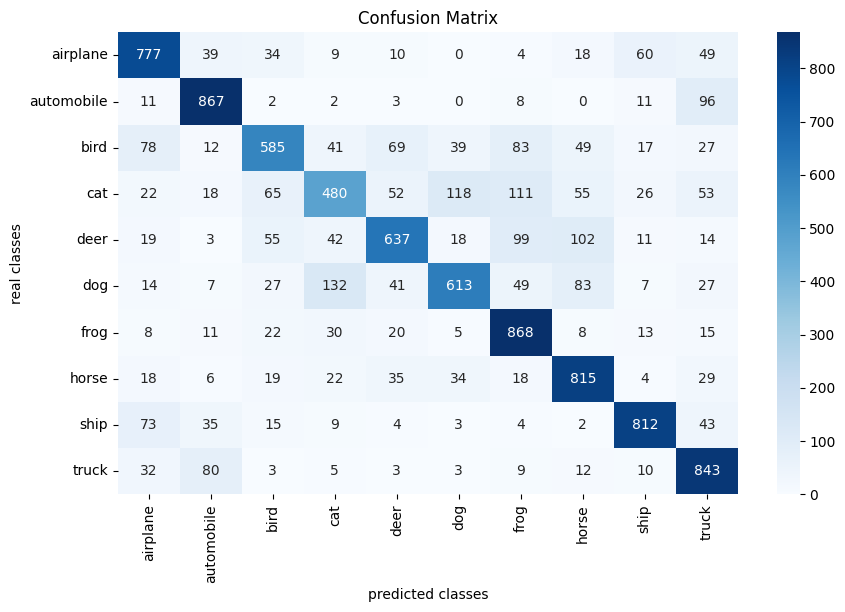

In [23]:
# calcolo della confusion matrix
# estraggo il vettore con le classi associate alle immagini
y_test_cm = np.concatenate([y.numpy() for x, y in test_ds], axis=0).flatten()

# calcolo le predizioni per ogni immagine
y_pred_cm = np.argmax(model.predict(test_ds, verbose=0), axis=1)

# calcolo la confusion matrix
cm = confusion_matrix(y_test_cm, y_pred_cm) # confuion matrix

plt.figure(figsize=(10, 6))
sns.heatmap(cm,
            annot=True,         # scrive i numeri nelle celle
            fmt='d',            # formato intero (no scientifico 1e2)
            cmap='Blues',       # colore (più scuro = più occorrenze)
            xticklabels=[class_names[i] for i in range(len(class_names))], # etichette asse orizzontale
            yticklabels=[class_names[i] for i in range(len(class_names))]  # etichette asse verticale
)
plt.xlabel('predicted classes')
plt.ylabel('real classes')
plt.title('Confusion Matrix',)
plt.show()

---
## 5. Calcolo di predizioni di immagin da internet

In [24]:
# lista degli url da internet e relative classi di appartenenza
url = [
    "https://drive.google.com/file/d/1pKQyiB3MsCg32KiPn9K0A9hsGB1-v-w8/view?usp=sharing", # airplane_1
    "https://drive.google.com/file/d/1_cikvWKzBkYxgxTf3JZ5i0Lpxu1omzDF/view?usp=sharing", # airplane_2
    "https://drive.google.com/file/d/1ibUec0F7hzTs-ongxi9YaIupXmQRdzqy/view?usp=sharing", # airplane_3
    "https://drive.google.com/file/d/1ER-FJjCwzwb72Zeo8oo71iHcjHJ9vPup/view?usp=sharing", # auto_1
    "https://drive.google.com/file/d/1QoUhEwYEyDGBH-VLvTE0TJ_NG5eCWA2f/view?usp=sharing", # auto_2
    "https://drive.google.com/file/d/1hhXlgiNnKqmAQ-tIPVlEdBcFG0DWaMB_/view?usp=sharing", # auto_3
    "https://drive.google.com/file/d/1PiPPtTKVPXqQx-rrZMT9jz7sfSn__lU8/view?usp=sharing", # bird_1
    "https://drive.google.com/file/d/1i2RAS7hjC8H3q_UN0gEIQWlk4c07nGad/view?usp=sharing", # bird_2
    "https://drive.google.com/file/d/1C0BuP3FeIXK6bHYasMR4yKX_5cjiawxG/view?usp=sharing", # bird_3
    "https://drive.google.com/file/d/1e_CHrUSU158aD8Cjnx7tg6mhlMtMBOBw/view?usp=sharing", # cat_1
    "https://drive.google.com/file/d/1nVpRvfFD9N5U1bJwb3VrLkgURcwVJmg5/view?usp=sharing", # cat_2
    "https://drive.google.com/file/d/18oT0tR0fNcrwUpBbbWzuHnY8vIncq5H3/view?usp=sharing", # cat_3
    "https://drive.google.com/file/d/1q8S9UTx5uipt5zJ-uCmDPMrO7sFcBd-5/view?usp=sharing", # deer_1
    "https://drive.google.com/file/d/1MeQc8ASlpm6CGZwKJp79mNFRxUrRpUyw/view?usp=sharing", # deer_2
    "https://drive.google.com/file/d/1Fav_knuhlTr2hcn3JjAKBK7lO9p_RYud/view?usp=sharing", # deer_3
    "https://drive.google.com/file/d/1GV1Ig0ClXTwPaFO1ykIQY25Mcj2h1fsU/view?usp=sharing", # dog_1
    "https://drive.google.com/file/d/1YBYVEzmVkLrvseEzSrT-gthVM0rcbS7k/view?usp=sharing", # dog_2
    "https://drive.google.com/file/d/1MomJAppy2ZDkac1WzAOLOsMU3cD6L66r/view?usp=sharing", # dog_3
    "https://drive.google.com/file/d/1FHPBjgT1-aLr5sbL1qUtOcwFId94s_FY/view?usp=sharing", # frog_1
    "https://drive.google.com/file/d/1RjLLXHvNsj67hiOE9uXrIgEMF6ZFfLyK/view?usp=sharing", # frog_2
    "https://drive.google.com/file/d/1fL740jRncIGnJJbXMiT0XlPZCf_m6GF_/view?usp=sharing", # frog_3
    "https://drive.google.com/file/d/1N4zoor-1jB5s0KXKDtSUS90rmFqa6maQ/view?usp=sharing", # horse_1
    "https://drive.google.com/file/d/16XKZuI3CYV00O0lmbhanf1C45a1dRucZ/view?usp=sharing", # horse_2
    "https://drive.google.com/file/d/1yyAnF87q22D1sOtBFrU1jM90SZ05RvpP/view?usp=sharing", # horse_3
    "https://drive.google.com/file/d/1Vdx7rx0MwwxD62nWlcTno2hjVwDFjkIw/view?usp=sharing", # ship_1
    "https://drive.google.com/file/d/1cjMdS4GYCaAIEP-E2V2hIN_L4m9QVmPq/view?usp=sharing", # ship_2
    "https://drive.google.com/file/d/1CuHfjiGL2DCo0UsNPgCANbuY7oBCATyh/view?usp=sharing", # ship_3
    "https://drive.google.com/file/d/1_70clAU8xif_jQdYOC_Igr6fRdq-K2RH/view?usp=sharing", # truck_1
    "https://drive.google.com/file/d/1ui00sdpTXQ-Vn9in8RqrG4Xj0Vf5jtAD/view?usp=sharing", # truck_2
    "https://drive.google.com/file/d/1e22S289o9gUqrGm0fOmV7ui9lke2i5oX/view?usp=sharing"  # truck_3
]

# funzione che riceve un url di un'immagine e restituisce il tensore dell'immagine
def get_image(url):
    gdown.download(url, "temp_image.jpg", quiet=True, fuzzy=True) # 1. download immagine dall'url
    img = image.load_img("temp_image.jpg", target_size=(32, 32))       # 2. caricamento e ridimensionamento immagine
    img_array = image.img_to_array(img)           # 3. trasformazione in array
    img_batch = np.expand_dims(img_array, axis=0) # 4. trasformazione in batch
    img_batch = img_batch / 255.0                 # 5. normalizzazione valori RGB
    return img_batch                              # 6. restituzione batch

# costruzione vettore di immagini in batch
images = np.array([get_image(u) for u in url])

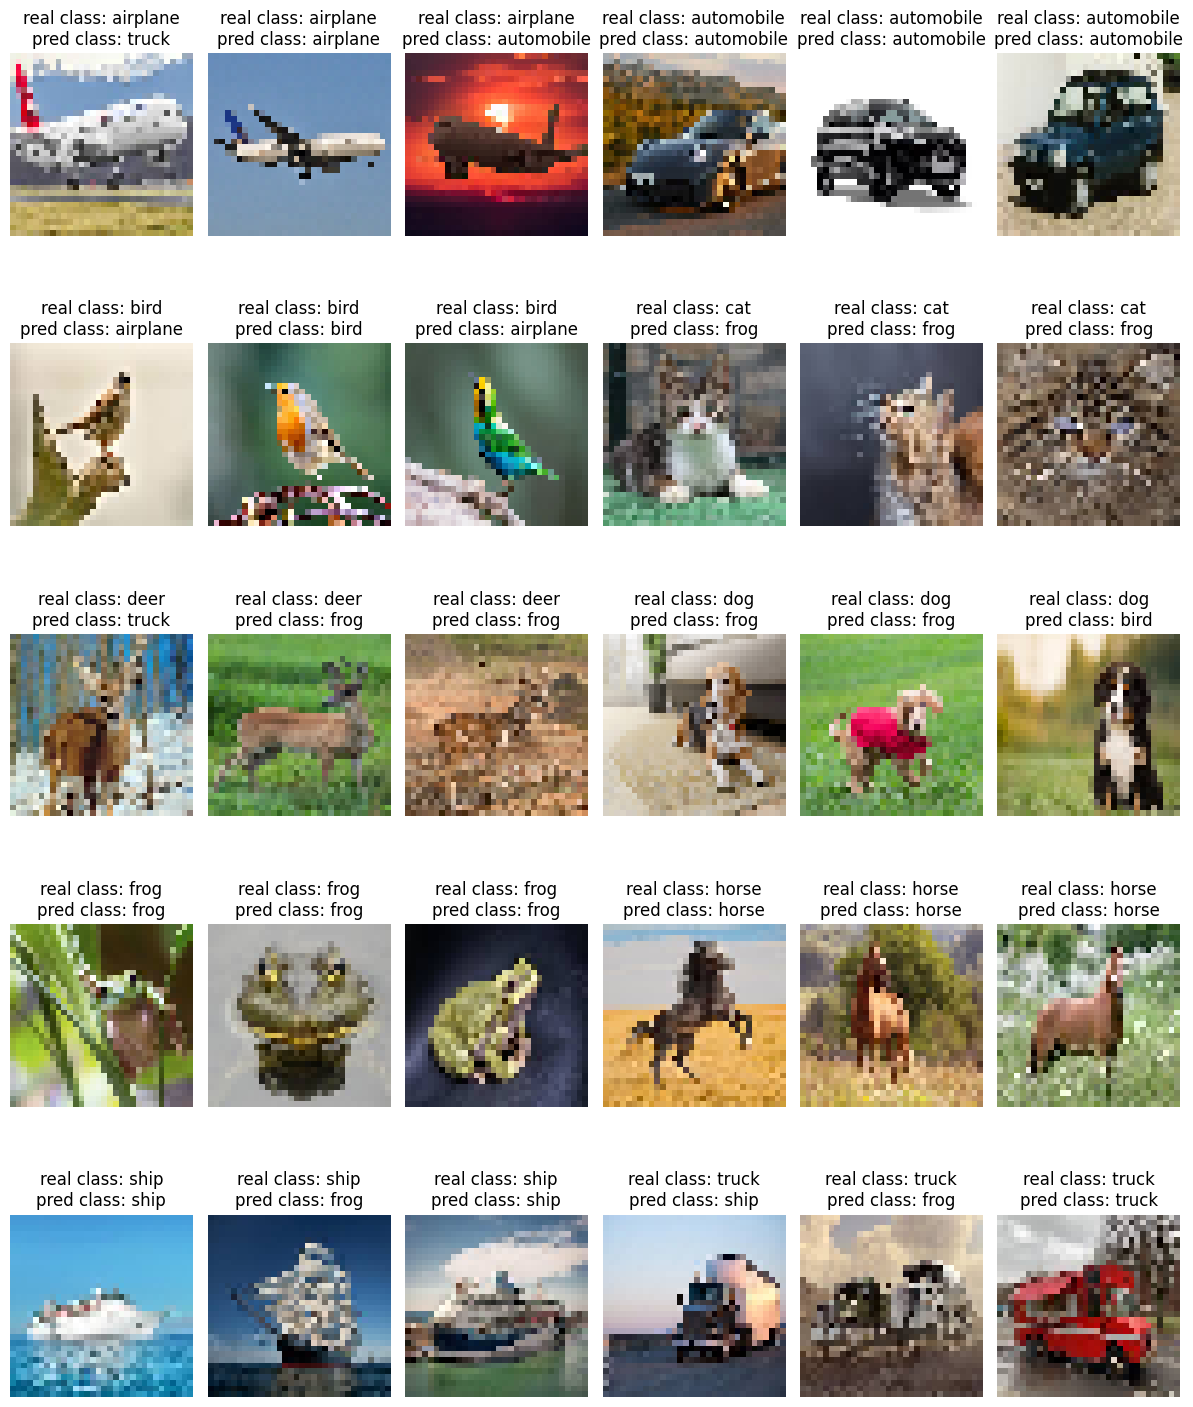

In [25]:
# calcolo classi
real_labels = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9]
pred_labels = np.array([np.argmax(model.predict(img, verbose=0), axis=1) for img in images]).flatten()

# stampa immagini
fig, axes = plt.subplots(5, 6, figsize=(12,15))
for ax, img, real_lbl, pred_lbl in zip(axes.flatten(), images, real_labels, pred_labels):
    ax.imshow(img.reshape(32,32,3).astype("float32"))
    ax.set_title("real class: " + class_names[real_lbl] + "\npred class: " + class_names[pred_lbl])
    ax.axis("off")
plt.tight_layout()
plt.show()